In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

import pickle
import numpy as np

from tqdm import tnrange, tqdm_notebook
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_palette("husl", 5)

## Import data and make dataset

In [2]:
X_train = pickle.load(open('Data/regression/X_train.pkl', 'rb'))
y_train = pickle.load(open('Data/regression/y_train.pkl', 'rb'))
X_test = pickle.load(open('Data/regression/X_test.pkl', 'rb'))
y_test = pickle.load(open('Data/regression/y_test.pkl', 'rb'))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [3]:
X_train.shape

(115779, 5, 200)

In [4]:
X_val.shape

(28945, 5, 200)

In [5]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)
val_ds = TensorDataset(X_val, y_val)

In [6]:
test = X_train[0].unsqueeze(0)

# conv1 = nn.Conv1d(5, 16, 5)
# conv2 = nn.Conv1d(16, 32, 5)
# nn.MaxPool1d(2)

# result1 = conv1(test)

# result2 = conv2(result1)

# result1.shape, result2.shape

# fc = nn.Linear(result2.shape[1]*result2.shape[2], 256)

# final = fc(result2.view(result2.size(0), -1))

# final.shape

## Define regression model

In [7]:
class LeNet_1D(nn.Module):
    def __init__(self, input_channel=5, dropout=0):
        super(LeNet_1D, self).__init__()

        self.conv1 = nn.Conv1d(input_channel, 16, 5)
        self.conv2 = nn.Conv1d(16, 32, 5)

        self.fc1 = nn.Linear(32*47, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

        self.convolutions = nn.Sequential(
            self.conv1,  # 5 -> 16
            nn.MaxPool1d(2),
            self.conv2,  # 16 -> 32
            nn.MaxPool1d(2)
        )
        self.linears = nn.Sequential(
            self.fc1,
            nn.LeakyReLU(),
            self.fc2,
            nn.LeakyReLU(),
            self.fc3
        )

    def forward(self, x):
        out = self.convolutions(x)
        out = out.view(out.size(0), -1)
        out = self.linears(out)
        return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

## training

In [8]:
def train(net, trainloader):
    net.train()
    
    lossSum = 0
    idx = 0
    
    for X, y in tqdm_notebook(trainloader, desc='dataset loop:'):
        X, y = X.to(device), y.to(device)
        idx += 1
        predict = net(X)
        optimizer.zero_grad()
        loss = criterion(predict, y)
        lossSum += loss.item()
        loss.backward()
        optimizer.step()
    
    return lossSum / idx


def validation(net, validationloader):
    net.eval()
    
    lossSum = 0
    idx = 0
    
    for X, y in validationloader:
        X, y = X.to(device), y.to(device)
        idx += 1
        predict = net(X)
        loss = criterion(predict, y)
        lossSum += loss.item()
    
    return lossSum / idx

In [9]:
net = LeNet_1D()
EPOCH = 200
gpu_idx = 0
batch_size = 100
learning_rate = 1e-3
weight_decay = 5e-6
tloss = []
vloss = []

device = 'cuda:%d' % gpu_idx if torch.cuda.is_available() else 'cpu'

trainloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=10)
validationloader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=10)

criterion = getattr(nn, 'MSELoss')()
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

## Training Code

In [10]:
import copy

In [11]:
best_model = None
best_val = 9999999
for epoch in tnrange(EPOCH, desc='epoch loop:'):
    net.to(device)
    train_loss = train(net, trainloader)
    val_loss = validation(net, validationloader)
    tloss.append(train_loss)
    vloss.append(val_loss)
    if val_loss < best_val:
        best_val = val_loss
        best_model = copy.deepcopy(net.cpu())

In [134]:
import matplotlib
matplotlib.rcParams["figure.dpi"] = 200

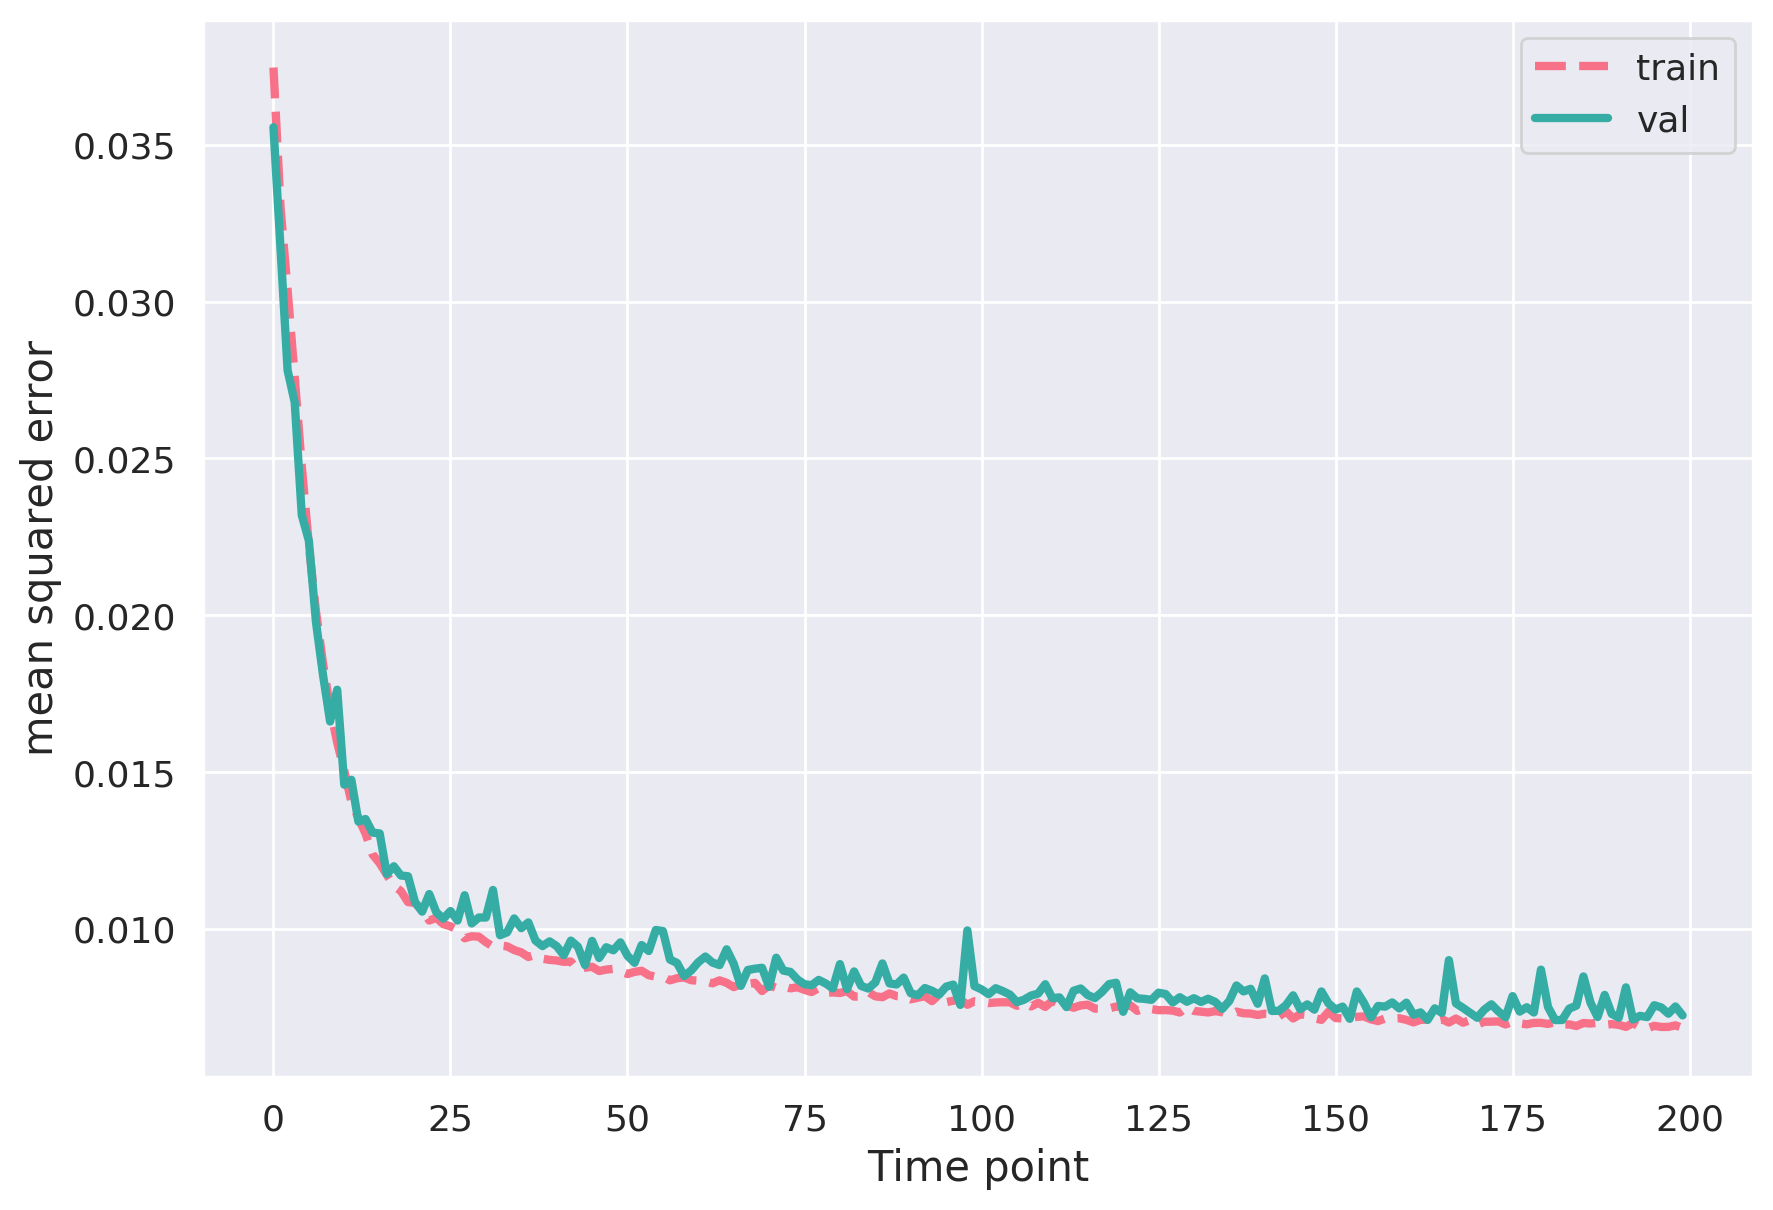

In [135]:
# plt.rcParams["figure.figsize"] = (8, 5)
# plt.plot(tloss, label='train')
# plt.plot(vloss, label='val')
# plt.legend(fontsize=15)
sns.set_palette('husl', n_colors=2)
plt.figure(figsize=(10,7))
plt.xlabel('Time point', fontsize=15)
plt.ylabel('mean squared error', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.plot(tloss, '--', label='train', linewidth=3)
plt.plot(vloss, label='val', linewidth=3)
plt.legend(fontsize=13)

plt.savefig('learning_curve.png', dpi=300)

200

- save model and losses

In [13]:
torch.save(best_model.state_dict(), 'model_save/lenet_regression_model.pt')

- load model

In [17]:
net.load_state_dict(torch.load('model_save/lenet_regression_model.pt'))

<All keys matched successfully>

In [14]:
test_loader = DataLoader(val_ds, batch_size=1, shuffle=True, num_workers=10)

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [16]:
best_model.to(device)
best_model.eval()

for X, y in test_loader:
    X, y = X.to(device), y.to(device)
    
    predict = best_model(X)
    
    break

## Adversarial Attack

In [17]:
from advertorch.attacks import LinfPGDAttack

In [18]:
adversary = LinfPGDAttack(
    best_model, loss_fn=nn.MSELoss(), eps=0.01,
    nb_iter=40, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
    targeted=False)

In [19]:
adv_untargeted = adversary.perturb(X, y)

In [20]:
predict_new = best_model(adv_untargeted)

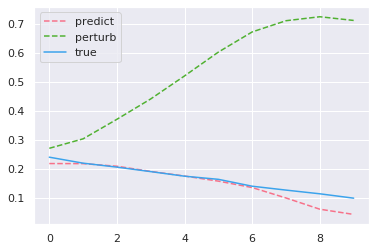

In [22]:
sns.set_palette("husl", 3)

plt.plot(predict.cpu().detach().numpy().squeeze(), '--', label='predict')
plt.plot(predict_new.cpu().detach().numpy().squeeze(), '--', label='perturb')
plt.plot(y.cpu().detach().numpy().squeeze(), label='true')
plt.legend()

## Testing

In [92]:
def test_model(test_loader):
    pred_list = np.zeros((test_loader.__len__(), 100, 10))
    y_list = np.zeros((test_loader.__len__(), 100, 10))
    X_list = np.zeros((test_loader.__len__(), 100, 5, 200))
    prev_list = np.zeros((test_loader.__len__(), 100, 200))
    
    for idx, (X, y) in tqdm_notebook(enumerate(test_loader)):
        # (torch.Size([100, 10]), torch.Size([100, 5, 200]), torch.Size([100, 10]))
        X, y = X.to(device), y.to(device)

        predict = best_model(X)

        pred_list[idx] = predict.cpu().detach().numpy().squeeze()
        y_list[idx] = y.cpu().detach().numpy().squeeze()
        X_list[idx] = X.cpu().detach().numpy().squeeze()
        prev_list[idx] = X[:,3,:].cpu().detach().numpy().squeeze()
        #     pred_list.append(predict.cpu().detach().numpy().squeeze())
        #     y_list.append(y.cpu().detach().numpy().squeeze())
        #     prev_list.append(X[:,3,:].cpu().detach().numpy().squeeze())

    pred_list = pred_list.reshape(-1,10)
    y_list = y_list.reshape(-1,10)
    prev_list = prev_list.reshape(-1, 200)
    
    return prev_list, X_list, y_list, pred_list

In [77]:
test_loader = DataLoader(val_ds, batch_size=100, shuffle=False, num_workers=10, drop_last=True)

### Perturbation

In [142]:
def attack_model(test_loader, eps=0.01, ratio=0.1):
    adversary = LinfPGDAttack(
        best_model, loss_fn=nn.MSELoss(), eps=eps,
        nb_iter=40, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
        targeted=False)
    limit = int(test_loader.__len__() * 0.1)
    perturb_list = np.zeros((test_loader.__len__(), 100, 10))
    adb_list = np.zeros((test_loader.__len__(), 100, 5, 200))
    pred_list = np.zeros((test_loader.__len__(), 100, 10))

    for idx, (X, y) in tqdm_notebook(enumerate(test_loader)):
        # (torch.Size([100, 10]), torch.Size([100, 5, 200]), torch.Size([100, 10]))
        X, y = X.to(device), y.to(device)
        
        if idx < limit:
            adv_untargeted = adversary.perturb(X, y)
            adb_list[idx] = adv_untargeted.cpu().detach().numpy()

            predict = best_model(adv_untargeted)
            perturb_list[idx] = predict.cpu().detach().numpy().squeeze()
        else:
            predict = best_model(X)
            perturb_list[idx] = predict.cpu().detach().numpy().squeeze()

    perturb_list = perturb_list.reshape(-1,10)
    adb_list = adb_list.reshape(-1, 5, 200)
    
    return perturb_list, adb_list

In [55]:
adv_untargeted.shape, predict.shape, y.shape

(torch.Size([100, 5, 200]), torch.Size([100, 10]), torch.Size([100, 10]))

In [79]:
test_loader = DataLoader(val_ds, batch_size=100, shuffle=False, num_workers=10, drop_last=True)

In [93]:
prev_list, X_list, y_list, pred_list = test_model(test_loader)

In [89]:
X_list = X_list.reshape(-1, 5, 200)

In [80]:

perturb_list_1, adb_list_1 = attack_model(test_loader, 0.1)
perturb_list_05, adb_list_05 = attack_model(test_loader, 0.05)
perturb_list_01, adb_list_01 = attack_model(test_loader, 0.01)
perturb_list_005, adb_list_005 = attack_model(test_loader, 0.005)
perturb_list_001, adb_list_001 = attack_model(test_loader, 0.001)

In [95]:
def plot_before_after(idx, adv_untargeted, X):
    sns.set_palette("husl", 5)

    plt.rcParams["figure.figsize"] = (20, 8)
    plt.rcParams["figure.titlesize"] = 21

    fig, ax = plt.subplots(1, 2)
#     idx = 76
    data = adv_untargeted[idx,:,:]
    new_data = X[idx,:,:]
    ax[0].plot(new_data.T)
    ax[0].legend(['ACCEL', 'CURRENT', 'PEDAL', 'SPEED', 'VOLTAGE'])
    ax[0].set_title('Before')
    ax[0].set_xlabel('df')

    ax[1].plot(data.T)
    ax[1].legend(['ACCEL', 'CURRENT', 'PEDAL', 'SPEED', 'VOLTAGE'])
    ax[1].set_title('After')
    plt.show()

In [ ]:
plt.plot()

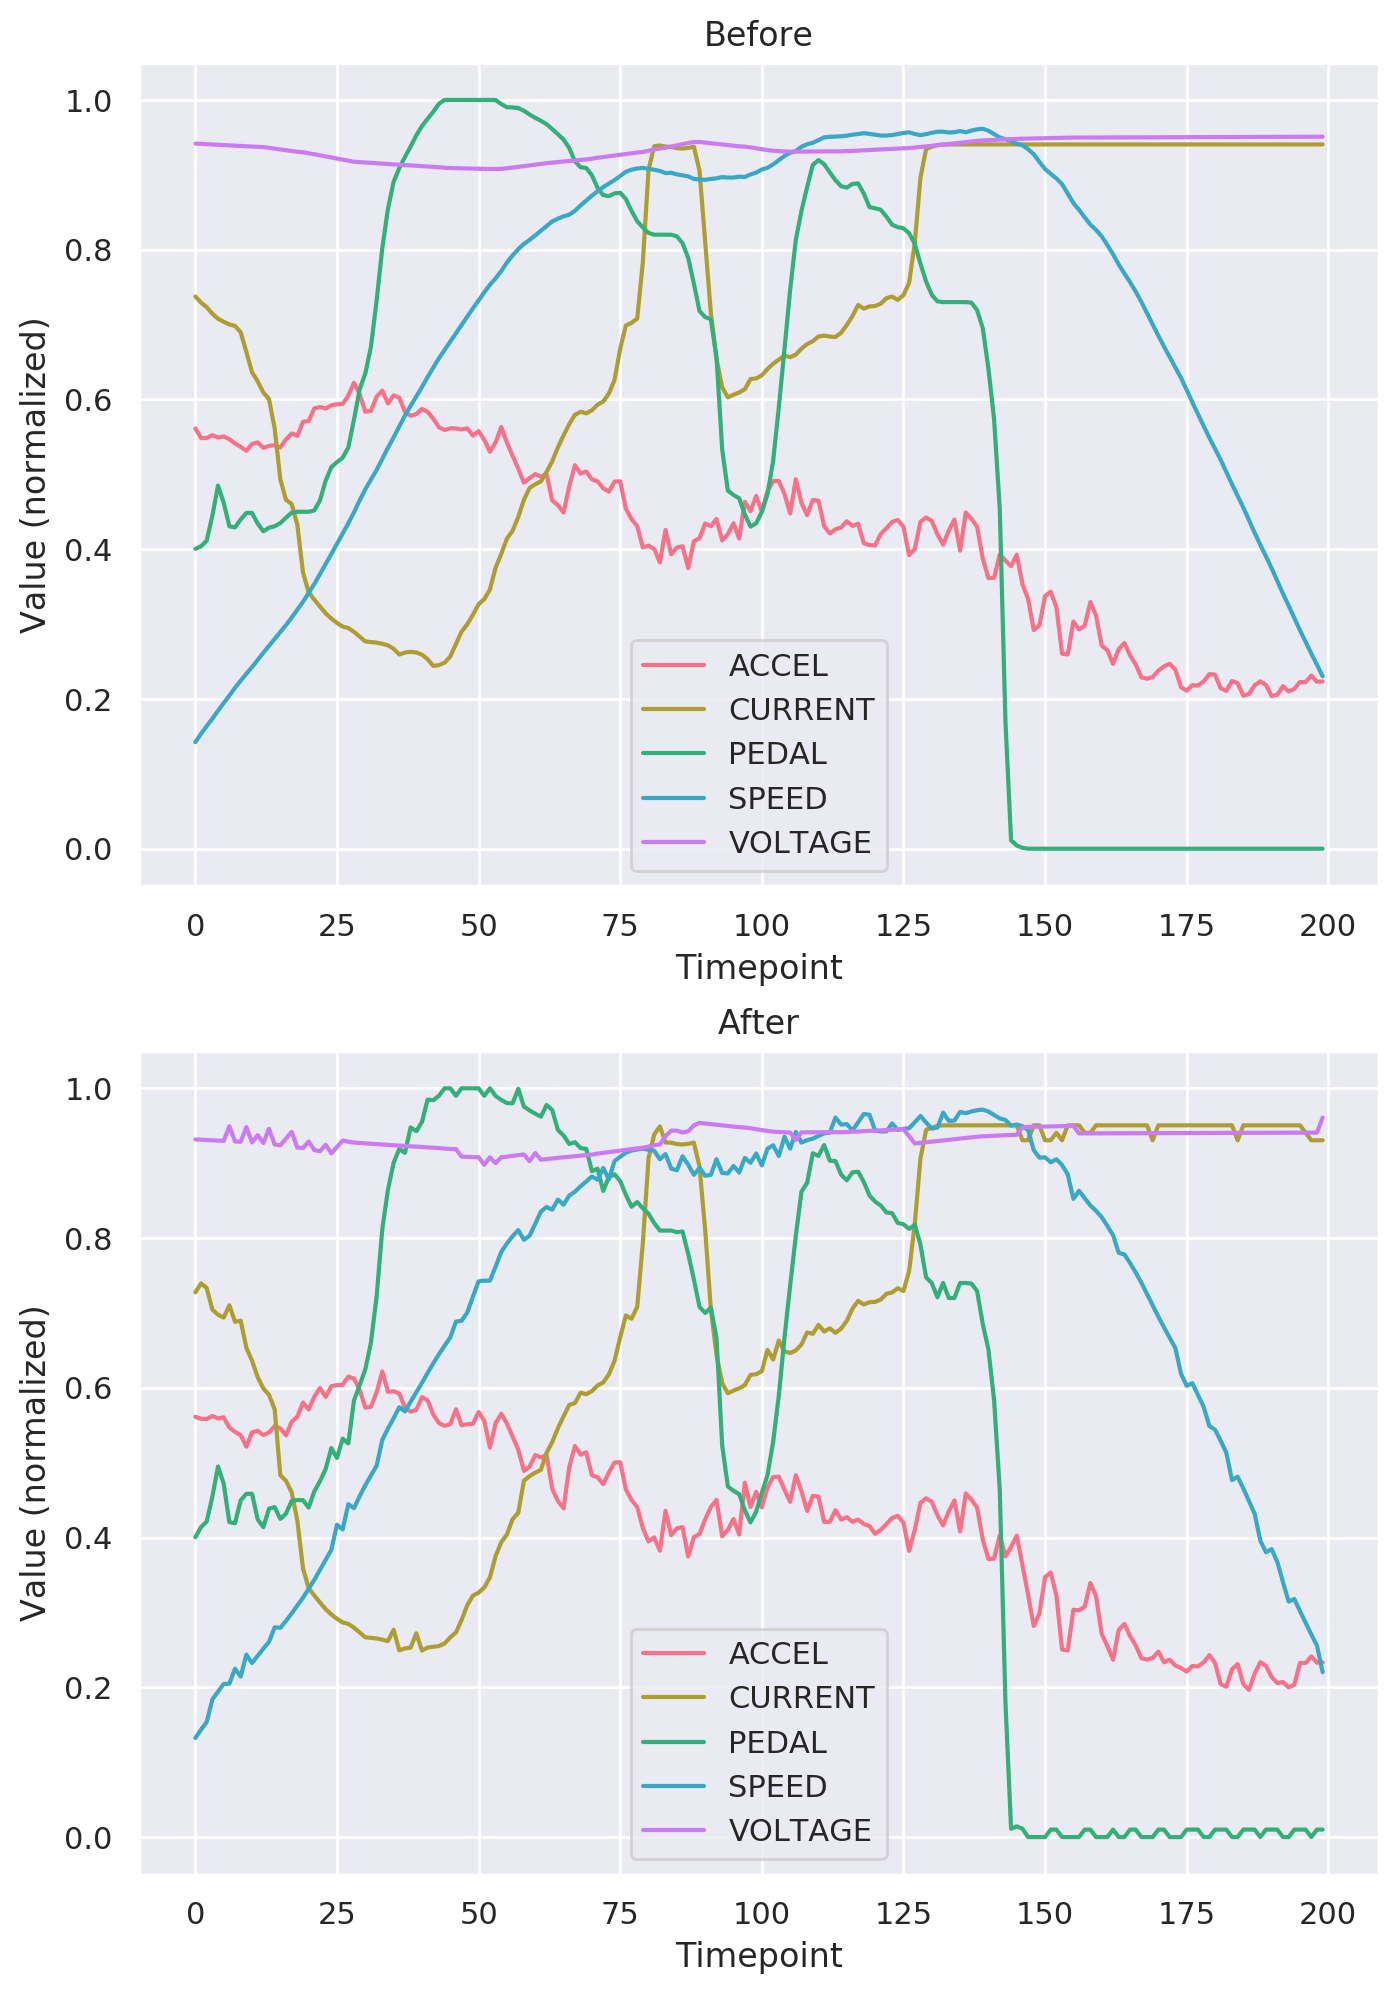

In [136]:
sns.set_palette("husl", 5)

plt.rcParams["figure.figsize"] = (8, 12)
plt.rcParams["figure.titlesize"] = 21

fig, ax = plt.subplots(2, 1)

idx = 76
data = adv_untargeted[idx,:,:].cpu().detach().numpy()
ax[0].plot(new_data.T)
ax[0].legend(['ACCEL', 'CURRENT', 'PEDAL', 'SPEED', 'VOLTAGE'])
ax[0].set_title('Before')
ax[0].set_xlabel('Timepoint')
ax[0].set_ylabel('Value (normalized)')

new_data = X[idx,:,:].cpu().detach().numpy()

ax[1].plot(data.T)
ax[1].legend(['ACCEL', 'CURRENT', 'PEDAL', 'SPEED', 'VOLTAGE'])
ax[1].set_title('After')
ax[1].set_xlabel('Timepoint')
ax[1].set_ylabel('Value (normalized)')
plt.show()


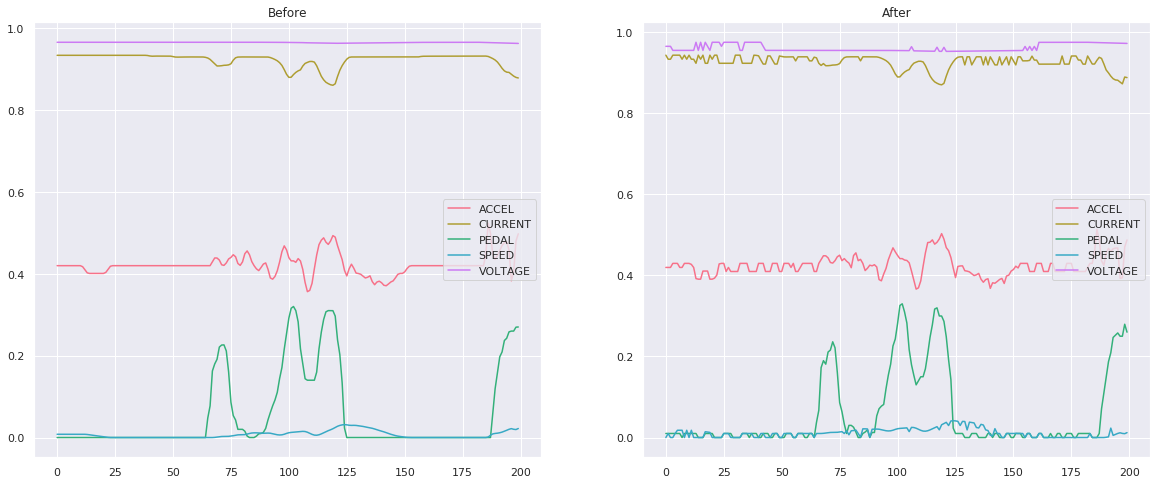

In [61]:
plot_before_after(15)

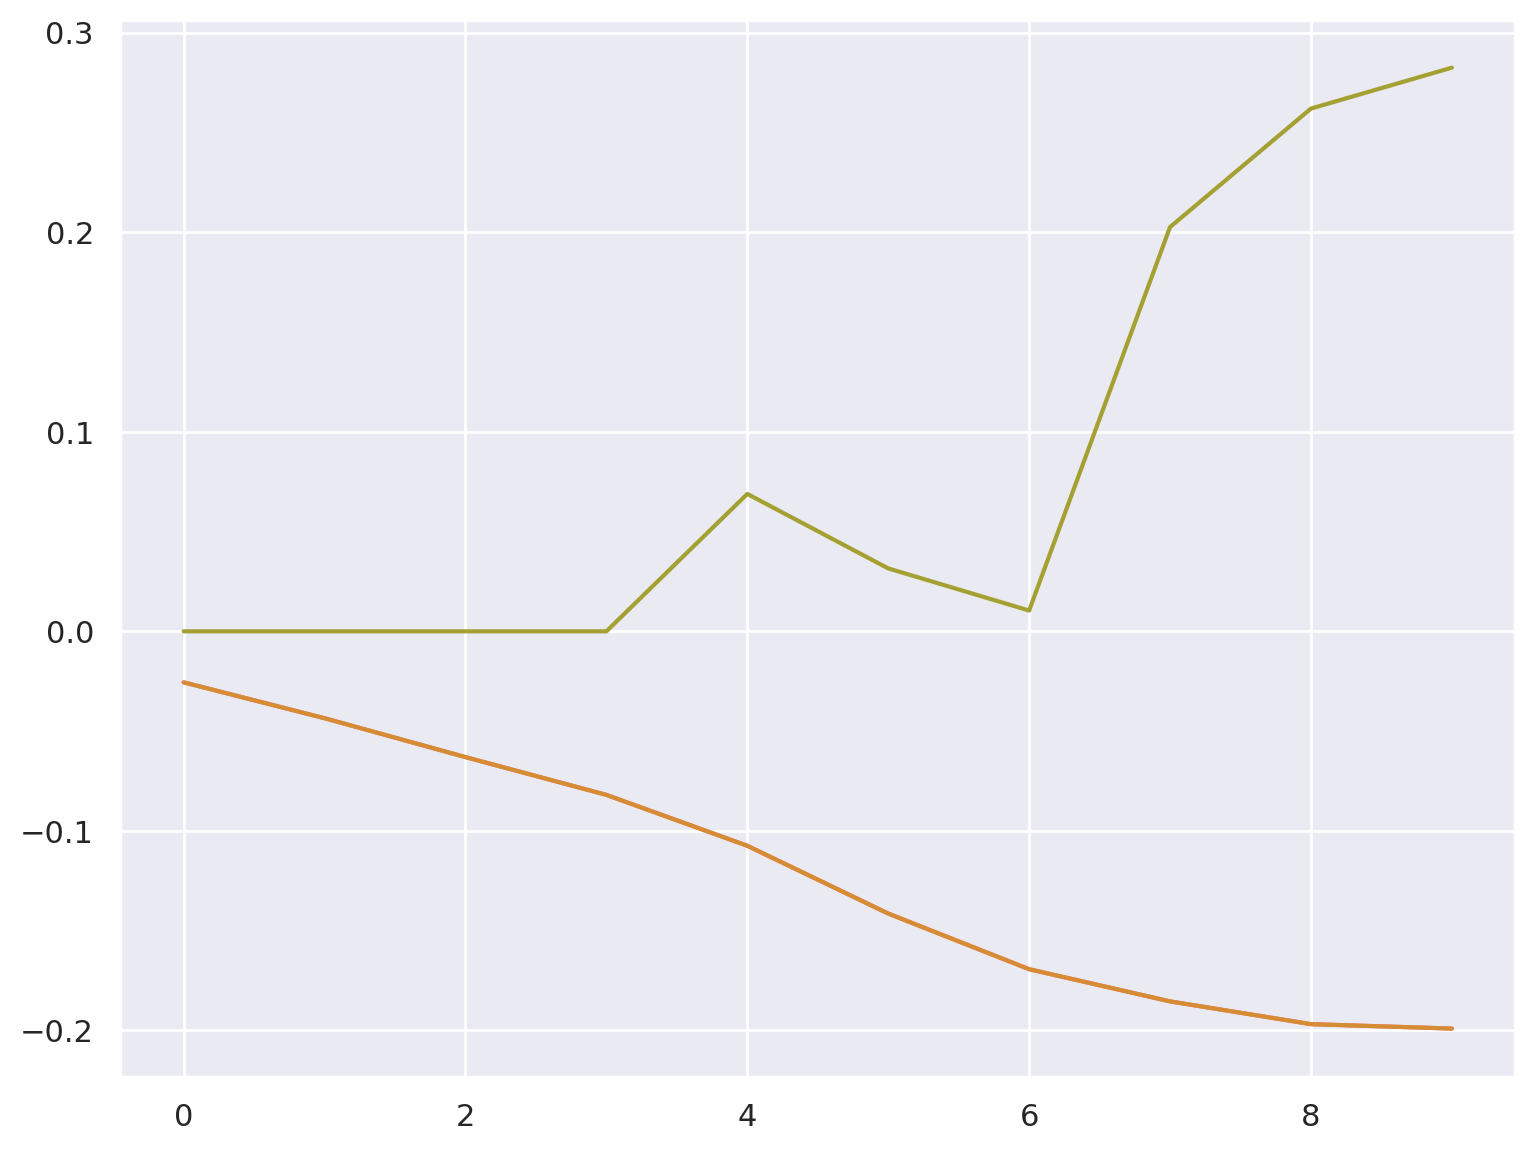

In [140]:
plt.rcParams["figure.figsize"] = (9, 7)
plt.plot(predict[0].cpu().detach().numpy().squeeze())
plt.plot(predict[0].cpu().detach().numpy().squeeze())
plt.plot(y[0].cpu().detach().numpy().squeeze())

In [108]:
perturb_list_04, adb_list_04 = attack_model(test_loader, 0.04)
perturb_list_03, adb_list_03 = attack_model(test_loader, 0.03)
perturb_list_02, adb_list_02 = attack_model(test_loader, 0.02)

In [109]:
mse_orig =  np.zeros(10)
mse_perturb_1 = np.zeros(10)
mse_perturb_05 = np.zeros(10)
mse_perturb_04 = np.zeros(10)
mse_perturb_03 = np.zeros(10)
mse_perturb_02 = np.zeros(10)
mse_perturb_01 = np.zeros(10)
mse_perturb_005 = np.zeros(10)
mse_perturb_001 = np.zeros(10)
for i in range(10):
    mse_orig[i] = mean_squared_error(y_list[:,i], pred_list[:, i])
    mse_perturb_1[i] = mean_squared_error(y_list[:,i], perturb_list_1[:, i])
    mse_perturb_05[i] = mean_squared_error(y_list[:,i], perturb_list_05[:, i])
    mse_perturb_04[i] = mean_squared_error(y_list[:,i], perturb_list_04[:, i])
    mse_perturb_03[i] = mean_squared_error(y_list[:,i], perturb_list_03[:, i])
    mse_perturb_02[i] = mean_squared_error(y_list[:,i], perturb_list_02[:, i])
    mse_perturb_01[i] = mean_squared_error(y_list[:,i], perturb_list_01[:, i])
    mse_perturb_005[i] = mean_squared_error(y_list[:,i], perturb_list_005[:, i])
    mse_perturb_001[i] = mean_squared_error(y_list[:,i], perturb_list_001[:, i])

In [37]:
adv_untargeted[:,0,:].min(), adv_untargeted[:,0,:].max()

(tensor(0.0854, device='cuda:0'), tensor(0.8497, device='cuda:0'))

In [38]:
adv_untargeted[:,2,:].min(), adv_untargeted[:,2,:].max()

(tensor(0., device='cuda:0'), tensor(1., device='cuda:0'))

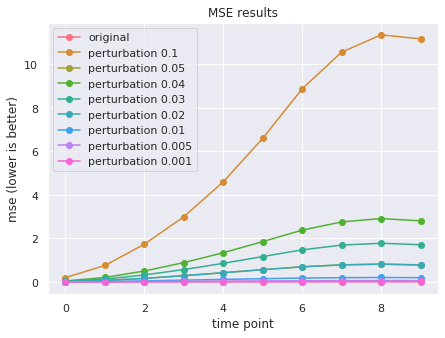

In [110]:
sns.set_palette("husl", 9)
plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["figure.titlesize"] = 21

# plt.ylim(0, 0.13)

plt.title('MSE results')
plt.ylabel('mse (lower is better)')
plt.xlabel('time point')

plt.plot(mse_orig, '-o', label='original')
plt.plot(mse_perturb_1, '-o', label='perturbation 0.1')
plt.plot(mse_perturb_05, '-o', label='perturbation 0.05')
plt.plot(mse_perturb_04, '-o', label='perturbation 0.04')
plt.plot(mse_perturb_03, '-o', label='perturbation 0.03')
plt.plot(mse_perturb_02, '-o', label='perturbation 0.02')
plt.plot(mse_perturb_01, '-o', label='perturbation 0.01')
plt.plot(mse_perturb_005, '-o', label='perturbation 0.005')
plt.plot(mse_perturb_001, '-o', label='perturbation 0.001')

plt.legend()

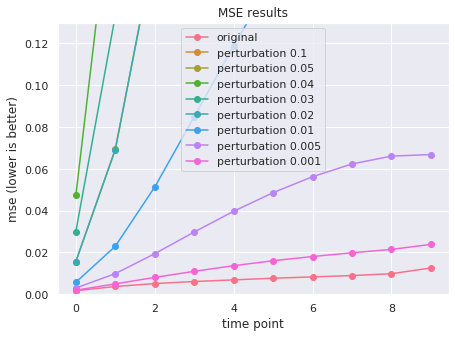

In [111]:
sns.set_palette("husl", 9)
plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["figure.titlesize"] = 21

plt.ylim(0, 0.13)

plt.title('MSE results')
plt.ylabel('mse (lower is better)')
plt.xlabel('time point')

plt.plot(mse_orig, '-o', label='original')
plt.plot(mse_perturb_1, '-o', label='perturbation 0.1')
plt.plot(mse_perturb_05, '-o', label='perturbation 0.05')
plt.plot(mse_perturb_04, '-o', label='perturbation 0.04')
plt.plot(mse_perturb_03, '-o', label='perturbation 0.03')
plt.plot(mse_perturb_02, '-o', label='perturbation 0.02')
plt.plot(mse_perturb_01, '-o', label='perturbation 0.01')
plt.plot(mse_perturb_005, '-o', label='perturbation 0.005')
plt.plot(mse_perturb_001, '-o', label='perturbation 0.001')

plt.legend()

In [ ]:
perturb_list_, adb_list_05 = attack_model(test_loader, 0.05, ratio=0.1)